In [2]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
%pylab inline

# We will ignore some silly warnings that pop up due to scikit-learn
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Adoption Data

In [131]:
df = pd.read_csv('aac_intakes_outcomes.csv')




#There's also a bunch of random animals in here that maybe skew the data (bats, possums). Let's take those out.
df['catordog'] = False
def catdogcheck(x):
    valid = ['Dog','Cat','Bird']
    if x in valid:
        return True
    return False
df['catordog'] = df['animal_type'].apply(catdogcheck)
cdmask = (df['catordog']==True)
df = df[cdmask]

df['animal_type'].value_counts()

Dog     45366
Cat     29539
Bird      339
Name: animal_type, dtype: int64

In [144]:
#Some filtering

#Convert 'age_upon_outcome' from string with 'year' into just the string with the number
def seperation(x):
    y = x.split(' ')
    return (y[0])
df['just_age'] = df['age_upon_outcome'].apply(seperation)

#Take out 'mix' from the breeds, condenses the number of dummy variables later on
def mixer(x):
    if 'Mix' in x:
        s = x.replace(' Mix','')
        return s
    return x
df['breed_nomix'] = df['breed'].apply(mixer)


#Now seperate the breed into bins based off frequency, arbitrarily set threshold at 100
num = df['breed_nomix'].value_counts()>100
a = df['breed_nomix'].value_counts()[num].index.tolist()
df['breed_bin'] = 'other'
def breedtest(x):
    if x in a:
        return x
    return 'other'
df['breed_bin'] = df['breed_nomix'].apply(breedtest)

#Get colors where the count is greater than 100, more relevant I guess this way
col = df['color'].value_counts()>100
b = df['color'].value_counts()[col].index.tolist()
df['color_bin'] = 'other'
def colortest(x):
    if x in b:
        return x
    return 'other'
df['color_bin'] = df['color'].apply(colortest)
#df['color_bin'].value_counts()

#Also filter out the unknown genders
gen = df['sex_upon_outcome'] != 'Unknown'
df = df[gen]
df['sex_upon_outcome'].value_counts()


Neutered Male    21791
Spayed Female    20649
Intact Female     7746
Intact Male       7360
Name: sex_upon_outcome, dtype: int64

In [146]:
# Setting up regressions using naive-bayes

# Should we filter out return to owner? seems logical because we want to look at actual strays, not ones that just got lost for a few days

mask = (df['outcome_type'] != 'Return to Owner')
df1 = df[mask]


# df1 now excludes all pets that were returned to owner, future analysis may include ones that were returned 
# after an extended period of time, for now it will only include long-term strays
df1['target_adopt'] = 0
mask = (df1['outcome_type']=='Adoption')
df1['target_adopt'][mask] = 1.0
#df1['target_adopt'].value_counts()

#Important to use categorical, most factors seem categorical except time in shelter (days), will qcut
df1['time_spent_shelter']= pd.qcut(df['time_in_shelter_days'],5)
#df1['time_spent_shelter'].value_counts()

#Seperate dates of birth into buckets as well
df1['DOB_DT'] = pd.to_datetime(df['date_of_birth'])
#df1['DOB_DT'][:5]
df1['DOB_bucket'] = pd.qcut(df1['DOB_DT'],5)
#df1['DOB_bucket'].value_counts()

#Change the age into a num and seperate into buckets
df1['age_upon_outcome_numeric']= pd.to_numeric(df1['just_age'])
df1['age_bucket'] = pd.qcut(df1['age_upon_outcome_numeric'],5)
#df1['age_bucket'].value_counts()

In [147]:
print df1.columns.values

#Going to use age_upon_outcome, date_of_birth, outcome_type, sex_upon_outocome, outcome_monthyear, outcome_weekday, outcome_hour, animal_type
#breed,color, intake_coundition, time_in_shelter_days

['age_upon_outcome' 'animal_id_outcome' 'date_of_birth' 'outcome_subtype'
 'outcome_type' 'sex_upon_outcome' 'age_upon_outcome_(days)'
 'age_upon_outcome_(years)' 'age_upon_outcome_age_group' 'outcome_datetime'
 'outcome_month' 'outcome_year' 'outcome_monthyear' 'outcome_weekday'
 'outcome_hour' 'outcome_number' 'dob_year' 'dob_month' 'dob_monthyear'
 'age_upon_intake' 'animal_id_intake' 'animal_type' 'breed' 'color'
 'found_location' 'intake_condition' 'intake_type' 'sex_upon_intake'
 'count' 'age_upon_intake_(days)' 'age_upon_intake_(years)'
 'age_upon_intake_age_group' 'intake_datetime' 'intake_month' 'intake_year'
 'intake_monthyear' 'intake_weekday' 'intake_hour' 'intake_number'
 'time_in_shelter' 'time_in_shelter_days' 'catordog' 'just_age'
 'breed_nomix' 'breed_bin' 'color_bin' 'target_adopt' 'time_spent_shelter'
 'DOB_DT' 'DOB_bucket' 'age_upon_outcome_numeric' 'age_bucket']


In [148]:
#Create categories to analyze
categorical_columns = ['age_bucket','DOB_bucket','sex_upon_outcome','animal_type',
                       'intake_condition','time_spent_shelter','breed_bin','color_bin']
df_dummies = pd.get_dummies(df1[categorical_columns],
                            prefix=categorical_columns,
                            columns=categorical_columns)
dummy_column_names = df_dummies.columns.values
dummy_column_names[:10]


array(['age_bucket_(-0.001, 1.0]', 'age_bucket_(1.0, 2.0]',
       'age_bucket_(2.0, 3.0]', 'age_bucket_(3.0, 5.0]',
       'age_bucket_(5.0, 25.0]',
       'DOB_bucket_(1991-12-10 23:59:59.999999999, 2012-07-28]',
       'DOB_bucket_(2012-07-28, 2014-03-18]',
       'DOB_bucket_(2014-03-18, 2015-04-03]',
       'DOB_bucket_(2015-04-03, 2016-04-17]',
       'DOB_bucket_(2016-04-17, 2018-03-24]'], dtype=object)

In [149]:
#Concatanate the columns and throw them together, then format
df2 = pd.concat([df1, df_dummies], axis=1)
formula = 'target_adopt ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in dummy_column_names]))
print formula

target_adopt ~ 0 + Q("age_bucket_(-0.001, 1.0]") + Q("age_bucket_(1.0, 2.0]") + Q("age_bucket_(2.0, 3.0]") + Q("age_bucket_(3.0, 5.0]") + Q("age_bucket_(5.0, 25.0]") + Q("DOB_bucket_(1991-12-10 23:59:59.999999999, 2012-07-28]") + Q("DOB_bucket_(2012-07-28, 2014-03-18]") + Q("DOB_bucket_(2014-03-18, 2015-04-03]") + Q("DOB_bucket_(2015-04-03, 2016-04-17]") + Q("DOB_bucket_(2016-04-17, 2018-03-24]") + Q("sex_upon_outcome_Intact Female") + Q("sex_upon_outcome_Intact Male") + Q("sex_upon_outcome_Neutered Male") + Q("sex_upon_outcome_Spayed Female") + Q("animal_type_Bird") + Q("animal_type_Cat") + Q("animal_type_Dog") + Q("intake_condition_Aged") + Q("intake_condition_Feral") + Q("intake_condition_Injured") + Q("intake_condition_Normal") + Q("intake_condition_Nursing") + Q("intake_condition_Other") + Q("intake_condition_Pregnant") + Q("intake_condition_Sick") + Q("time_spent_shelter_(-0.000306, 2.92]") + Q("time_spent_shelter_(2.92, 5.08]") + Q("time_spent_shelter_(5.08, 9.983]") + Q("time_s

In [150]:
#Make the matrix
Y, X = dmatrices(formula, df2, return_type='dataframe')
y = Y['target_adopt'].values
y[:10]

array([ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.])

In [151]:
from sklearn import naive_bayes
model = naive_bayes.MultinomialNB()
model.fit(X,y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [152]:
print 'Prediction'
print model.predict(X[:10])
print 'Actual'
print y[:10]

Prediction
[ 1.  1.  1.  0.  1.  0.  0.  0.  0.  1.]
Actual
[ 0.  0.  1.  0.  1.  0.  0.  0.  0.  1.]


In [153]:
#What's the accuracy of our predictions
from sklearn import metrics
prediction_train = model.predict(X)
print metrics.accuracy_score(y, prediction_train)

0.803930768429


In [154]:
print 'Prior probability for the negative class is',
print exp(model.class_log_prior_[0])
print 'Prior probability for the positive class is',
print exp(model.class_log_prior_[1])

Prior probability for the negative class is 0.420967573767
Prior probability for the positive class is 0.579032426233


In [155]:
feature_importances = abs(model.feature_log_prob_[1] - model.feature_log_prob_[0])
feature_importance_series = Series(feature_importances, index=X.columns.values)
top_10_feature_indices = feature_importance_series.sort_values(ascending=False)[:10].index.values
inter_class_differences = model.feature_log_prob_[1] - model.feature_log_prob_[0]
new_feature_importance_series = Series(inter_class_differences, index=X.columns.values)

new_feature_importance_series[top_10_feature_indices]


Q("sex_upon_outcome_Intact Male")            -2.685773
Q("sex_upon_outcome_Intact Female")          -2.568252
Q("breed_bin_Shih Tzu")                      -1.863499
Q("time_spent_shelter_(-0.000306, 2.92]")    -1.814789
Q("intake_condition_Feral")                  -1.587111
Q("intake_condition_Sick")                   -1.363791
Q("time_spent_shelter_(30.253, 1268.975]")    1.332277
Q("color_bin_Gray Tabby")                    -1.219387
Q("intake_condition_Other")                  -1.024819
Q("intake_condition_Nursing")                -0.966405
dtype: float64

# Above is naive bayes for a whole bunch of different categorical variables, let's try to find more specifics and put in some graphs/charts 

In [156]:
# Let's work with naive bayes regression for just breed and color and sex first.
#For simplification, ignoring breed and color for now
categorical_columns1 = ['breed_bin','color_bin','sex_upon_outcome']
df_dummies = pd.get_dummies(df1[categorical_columns1],
                            prefix=categorical_columns1,
                            columns=categorical_columns1)
dummy_column_names = df_dummies.columns.values
dummy_column_names[:10]

array(['breed_bin_American Bulldog', 'breed_bin_American Pit Bull Terrier',
       'breed_bin_American Shorthair',
       'breed_bin_American Staffordshire Terrier',
       'breed_bin_Anatol Shepherd', 'breed_bin_Australian Cattle Dog',
       'breed_bin_Australian Kelpie', 'breed_bin_Australian Shepherd',
       'breed_bin_Beagle', 'breed_bin_Black Mouth Cur'], dtype=object)

In [157]:
#Concatanate the columns and throw them together, then format
df2 = pd.concat([df1, df_dummies], axis=1)
formula = 'target_adopt ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in dummy_column_names]))
print formula

target_adopt ~ 0 + Q("breed_bin_American Bulldog") + Q("breed_bin_American Pit Bull Terrier") + Q("breed_bin_American Shorthair") + Q("breed_bin_American Staffordshire Terrier") + Q("breed_bin_Anatol Shepherd") + Q("breed_bin_Australian Cattle Dog") + Q("breed_bin_Australian Kelpie") + Q("breed_bin_Australian Shepherd") + Q("breed_bin_Beagle") + Q("breed_bin_Black Mouth Cur") + Q("breed_bin_Border Collie") + Q("breed_bin_Border Terrier") + Q("breed_bin_Boxer") + Q("breed_bin_Cairn Terrier") + Q("breed_bin_Catahoula") + Q("breed_bin_Chicken") + Q("breed_bin_Chihuahua Longhair") + Q("breed_bin_Chihuahua Shorthair") + Q("breed_bin_Chihuahua Shorthair/Dachshund") + Q("breed_bin_Chow Chow") + Q("breed_bin_Dachshund") + Q("breed_bin_Dachshund/Chihuahua Shorthair") + Q("breed_bin_Doberman Pinsch") + Q("breed_bin_Domestic Longhair") + Q("breed_bin_Domestic Medium Hair") + Q("breed_bin_Domestic Shorthair") + Q("breed_bin_German Shepherd") + Q("breed_bin_German Shepherd/Labrador Retriever") + Q(

In [158]:
#Make the matrix
B, A = dmatrices(formula, df2, return_type='dataframe')
b = B['target_adopt'].values
b[:10]

array([ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.])

In [159]:
model1 = naive_bayes.MultinomialNB()
model1.fit(A,b)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [160]:
print 'Prediction'
print model1.predict(A[:10])
print 'Actual'
print b[:10]

Prediction
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Actual
[ 0.  0.  1.  0.  1.  0.  0.  0.  0.  1.]


In [161]:
prediction_train = model1.predict(A)
print metrics.accuracy_score(b, prediction_train)

0.794894519167


In [162]:
feature_importances = abs(model1.feature_log_prob_[1] - model1.feature_log_prob_[0])
feature_importance_series = Series(feature_importances, index=A.columns.values)
top_10_feature_indices = feature_importance_series.sort_values(ascending=False)[:10].index.values
inter_class_differences = model.feature_log_prob_[1] - model.feature_log_prob_[0]
new_feature_importance_series = Series(inter_class_differences, index=X.columns.values)

new_feature_importance_series[top_10_feature_indices]

Q("sex_upon_outcome_Intact Male")                   -2.685773
Q("sex_upon_outcome_Intact Female")                 -2.568252
Q("breed_bin_Shih Tzu")                             -1.863499
Q("color_bin_Gray Tabby")                           -1.219387
Q("breed_bin_Staffordshire")                         0.959598
Q("sex_upon_outcome_Spayed Female")                  0.875474
Q("breed_bin_German Shepherd/Labrador Retriever")    0.791847
Q("color_bin_Black/Tricolor")                        0.768036
Q("breed_bin_Siberian Husky")                        0.766940
Q("breed_bin_Cairn Terrier")                         0.740792
dtype: float64

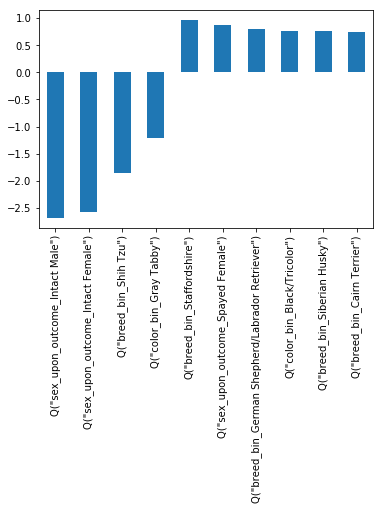

In [163]:
new_feature_importance_series[top_10_feature_indices].plot(kind = 'bar')
show()

In [71]:
#Conclusion, looks like there's a similar amount of adoptions vs non-adoptions, but most people don't adopt 
# bats, raccoon, opossums, etc.'
df1['target_adopt'].value_counts()/len(df1)

1    0.517779
0    0.482221
Name: target_adopt, dtype: float64

In [84]:
#We should focus more specifically on dogs and cats
dcmask = (df1['animal_type'] == "Dog")
dc = df1[dcmask]
df1['animal_type'].value_counts()

Dog      32093
Cat      28068
Other     4390
Bird       330
Name: animal_type, dtype: int64

In [143]:
df1['sex_upon_outcome'].value_counts()

Neutered Male    21791
Spayed Female    20649
Intact Female     7746
Intact Male       7360
Unknown           2945
Name: sex_upon_outcome, dtype: int64